In [1]:
from reliability.Fitters import Fit_Weibull_2P
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel('.\data.xlsx')

## Weibull plot de todas los sistemas

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 4713/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         1750.31         42.5134   1668.94   1835.65
     Beta        0.629671      0.00744391  0.615249  0.644432 

Goodness of fit    Value
 Log-likelihood -40408.7
           AICc  80821.4
            BIC  80834.4
             AD  18.1111 



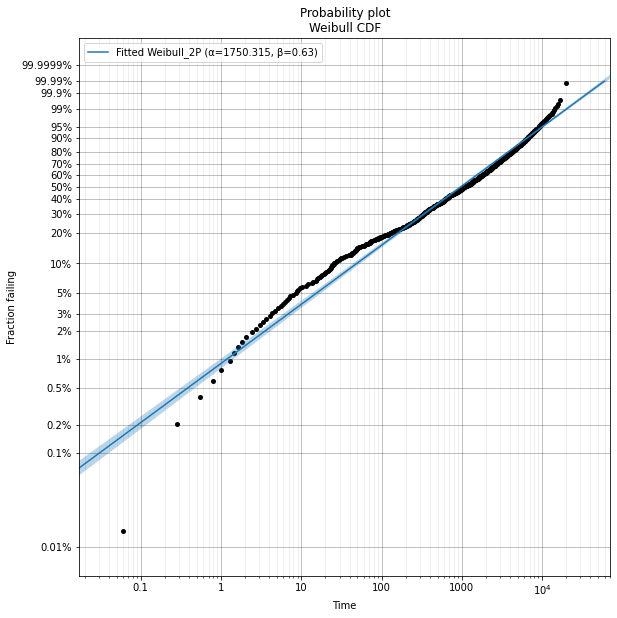

In [4]:
wb = Fit_Weibull_2P(failures=df.TBF.to_list())
plt.show()

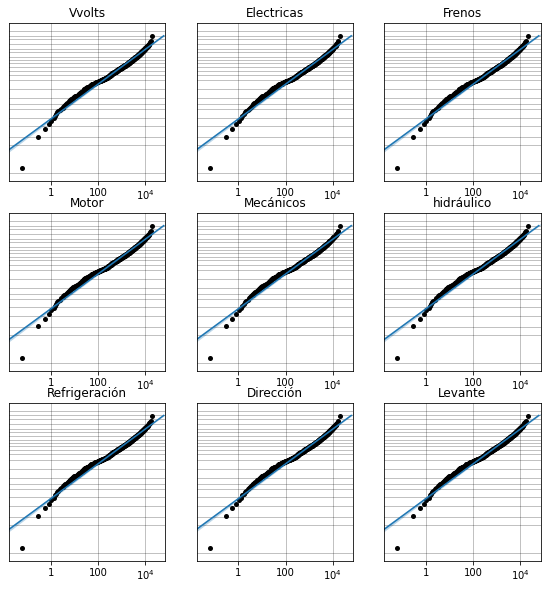

In [26]:
plt.figure(figsize=(12, 5))
i = 0
for s in df.SISTEMA.unique():
    plt.subplot(int('33'+str(i+1)))
    data = df[df.SISTEMA ==s].TBF.to_list() 
    wf = Fit_Weibull_2P(failures=df.TBF.to_list(),print_results=False)
    plt.legend().set_visible(False)
    plt.xlabel('')
    plt.ylabel('')
    plt.tick_params(left = False, right = False , labelleft = False)
    plt.title(s)
    i += 1

# Mixtura de Distribuciones en base a las funciones de superbvivencia que se obtienen desde los modelos de Cox y WeibullAFT

$$ S(t,\textbf{x},\boldsymbol{\Theta}) = \sum_{s\in\mathcal{S}} \omega_s S^M_s(t,\textbf{x},\Theta_s) \hspace{1cm},\hspace{1cm} \sum_{s\in\mathcal{S}} \omega_s = 1.$$

## Se considera $M\in \mathcal{M} \hspace{0.2cm}$ y $ \hspace{0.2cm}\omega_s=\frac{1}{9} \hspace{0.2cm} \forall s\in\mathcal{S}$

In [28]:
from lifelines import CoxPHFitter
from lifelines import WeibullAFTFitter

In [ ]:
cols_to_drop = ['FALLA','FECHA','REP','CAEX','SISTEMA']
wbfs = []
coxs = []
for s in df.SISTEMA.unique():
    data = df[df.SISTEMA ==s]
    data_to_eval = data.drop(cols_to_drop,axis=1).reset_index(drop=True)
    
    try:
        wbf  = WeibullAFTFitter().fit(data_to_eval, duration_col='TBF')
        cox = CoxPHFitter().fit(data_to_eval, duration_col='TBF')

        wbfs = pd.concat([wbfs,wbf.predict_survival_function(data_to_eval).mean(axis=1)*(1/9)],axis=1)
        coxs = pd.concat([coxs,cox.predict_survival_function(data_to_eval).mean(axis=1)*(1/9)],axis=1)
    except:
        
        i=0
        lambdas = np.linspace(1e-4, 0.1, 1000)
        flag = True
        while flag:
            try:
                wbf  = WeibullAFTFitter(l1_ratio=1., penalizer=lambdas[i]).fit(data_to_eval, duration_col='TBF')
                cox = CoxPHFitter(l1_ratio=1., penalizer=lambdas[i]).fit(data_to_eval, duration_col='TBF')
                flag =False
            except:
                i+=1
                    
    wbfs.append(wbf.predict_survival_function(data_to_eval).mean(axis=1)*(1/9))
    coxs.append(cox.predict_survival_function(data_to_eval).mean(axis=1)*(1/9))
coxs = pd.concat(coxs).reset_index().rename(columns={'index':'TBF',0:'Cox SF Mixture'}).sort_values(by='TBF').set_index('TBF')
wbfs = pd.concat(wbfs).reset_index().rename(columns={'index':'TBF',0:'Weibull AFT SF Mixture'}).sort_values(by='TBF').set_index('TBF')

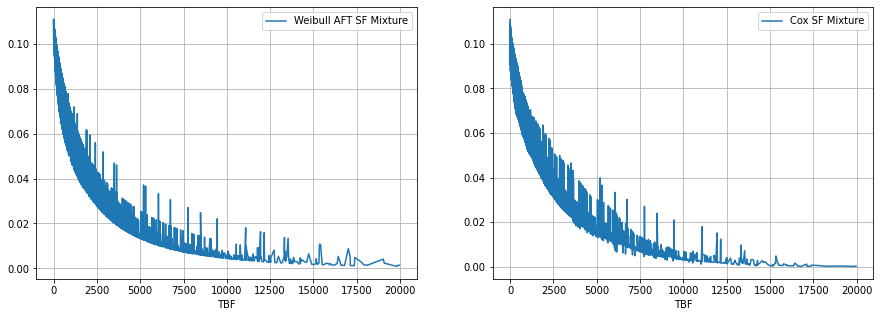

In [88]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
coxs.plot(ax=ax[1])
wbfs.plot(ax=ax[0])
ax[0].grid('on')
ax[1].grid('on')

### Ahora se grafican los Weibull-Plots para cada una de estas Funciones de Supervivencia Mixtas

In [229]:
df_pplot = pd.DataFrame(df.TBF).sort_values(by='TBF')
df_pplot['Fraction Failing'] = [100*i/len(df_pplot) for i in range(1,len(df_pplot)+1)]

cox_pplot = pd.DataFrame(np.log(np.log(1/coxs['Cox SF Mixture'])))
wbf_pplot = pd.DataFrame(np.log(np.log(1/wbfs['Weibull AFT SF Mixture'])))

aux_cox = (cox_pplot - cox_pplot.min() )/(cox_pplot.max() - cox_pplot.min() )
aux_wbf = (wbf_pplot - wbf_pplot.min() )/(wbf_pplot.max() - wbf_pplot.min() )

ff_cox_pplot = []
for  i in df_pplot['Fraction Failing']:
    ff_cox_pplot.append(len(aux_cox[aux_cox['Cox SF Mixture'] <i/100]))
    
ff_wbf_pplot = []
for  i in df_pplot['Fraction Failing']:
    ff_wbf_pplot.append(len(aux_wbf[aux_wbf['Weibull AFT SF Mixture'] <i/100]))
    
cox_pplot['ff'] = [100*x/len(cox_pplot) for x in ff_cox_pplot]
wbf_pplot['ff'] = [100*x/len(wbf_pplot) for x in ff_wbf_pplot]

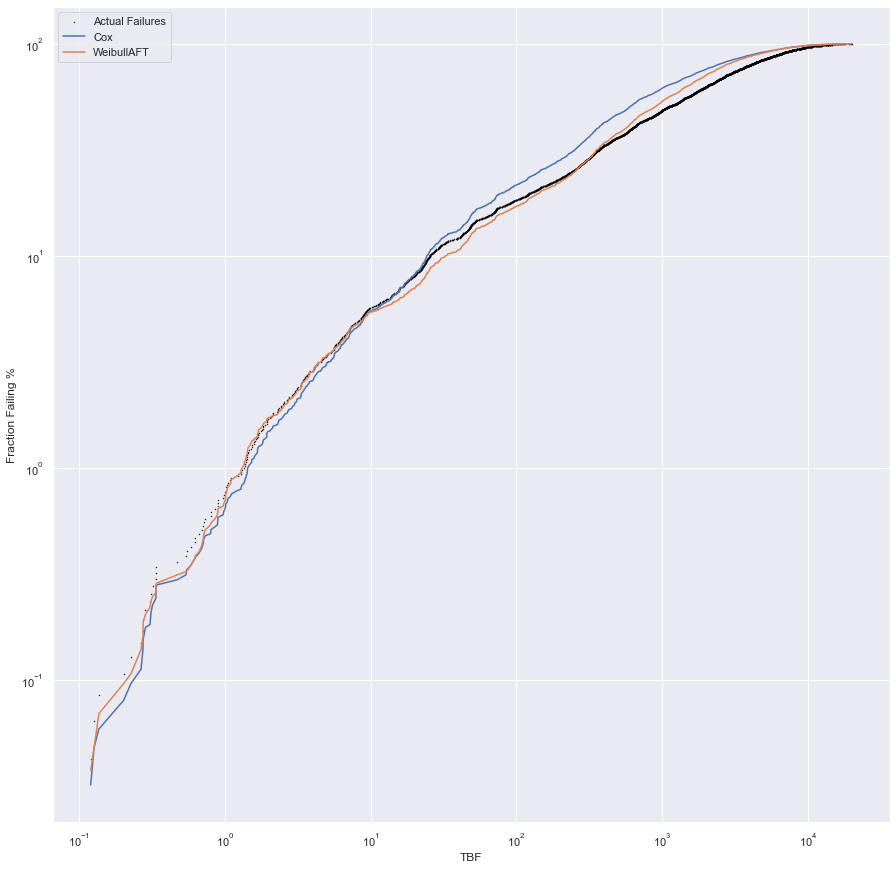

In [525]:
fig, ax = plt.subplots(figsize=(15,15))
df_pplot.plot.scatter(x='TBF',y='Fraction Failing',label= 'Actual Failures',logx=True,logy=True,color='black',s=0.2,ax=ax)

cox_pplot[['ff']].plot(label= 'Cox',logx=True,logy=True,ax=ax)
wbf_pplot[['ff']].plot(label= 'WeibullAFT',logx=True,logy=True,ax=ax)

ax.set_ylabel('Fraction Failing %')
ax.legend(['Actual Failures','Cox', 'WeibullAFT'])

ax.grid('on')